/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 63.3MB/s]


Running style transfer...
Step 50 | Style Loss: 0.0001 | Content Loss: 17.7656
Step 100 | Style Loss: 0.0000 | Content Loss: 17.2961
Step 150 | Style Loss: 0.0000 | Content Loss: 15.5662
Step 200 | Style Loss: 0.0000 | Content Loss: 15.2667
Step 250 | Style Loss: 0.0001 | Content Loss: 16.8242
Step 300 | Style Loss: 0.0606 | Content Loss: 39.0672


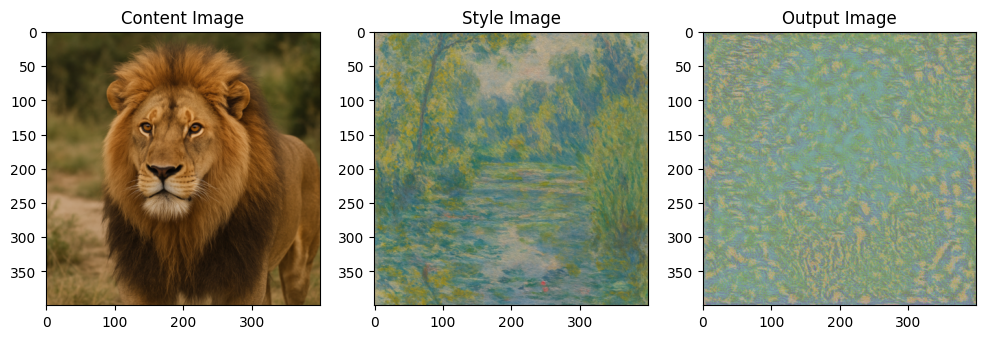

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import copy

# Load images
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    size = max_size if max(image.size) > max_size else max(image.size)
    if shape:
        size = shape
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],  # ImageNet
            std=[0.229, 0.224, 0.225]
        )
    ])
    image = in_transform(image)[:3, :, :].unsqueeze(0)
    return image

# Display image
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach().squeeze(0)
    image = image.numpy().transpose(1, 2, 0)
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    return image.clip(0, 1)

# Define content and style losses
class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target.detach()
    def forward(self, x):
        self.loss = nn.functional.mse_loss(x, self.target)
        return x

def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(c, h * w)
    G = torch.mm(features, features.t())
    return G.div(c * h * w)

class StyleLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = gram_matrix(target).detach()
    def forward(self, x):
        G = gram_matrix(x)
        self.loss = nn.functional.mse_loss(G, self.target)
        return x

# Load VGG19
cnn = models.vgg19(pretrained=True).features.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = cnn.to(device)

# Image paths
content_img = load_image("content_img.png").to(device)
style_img = load_image("style_image.png", shape=content_img.shape[-2:]).to(device)
input_img = content_img.clone()

# Layers to use
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# Build model with losses
def get_style_model_and_losses(cnn, style_img, content_img):
    cnn = copy.deepcopy(cnn)
    content_losses = []
    style_losses = []

    model = nn.Sequential()
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f"conv_{i}"
        elif isinstance(layer, nn.ReLU):
            name = f"relu_{i}"
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f"pool_{i}"
        elif isinstance(layer, nn.BatchNorm2d):
            name = f"bn_{i}"
        else:
            continue

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target = model(style_img).detach()
            style_loss = StyleLoss(target)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # Trim unused layers
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], (ContentLoss, StyleLoss)):
            break
    model = model[:i+1]

    return model, style_losses, content_losses

# Run style transfer
def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300,
                       style_weight=1e6, content_weight=1):
    model, style_losses, content_losses = get_style_model_and_losses(cnn, style_img, content_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print("Running style transfer...")
    run = [0]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = sum(sl.loss for sl in style_losses)
            content_score = sum(cl.loss for cl in content_losses)
            loss = style_weight * style_score + content_weight * content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"Step {run[0]} | Style Loss: {style_score.item():.4f} | Content Loss: {content_score.item():.4f}")
            return loss

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    return input_img

# Apply style transfer
output = run_style_transfer(cnn, content_img, style_img, input_img)

# Show output
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Content Image")
plt.imshow(im_convert(content_img))
plt.subplot(1, 3, 2)
plt.title("Style Image")
plt.imshow(im_convert(style_img))
plt.subplot(1, 3, 3)
plt.title("Output Image")
plt.imshow(im_convert(output))
plt.show()
